# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs

In [9]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-notebook')

In [10]:
plt.rcParams.update({'xtick.labelsize':13,'ytick.labelsize':13})

In [11]:
#plt.rcParams.keys()
PLOTPATH ='/global/homes/v/vboehm/codes/MADLens/figures' 

In [12]:
from MADLens.util import *

### load TNG power spectra and interpolate 

/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  This is separate from the ipykernel package so we can avoid doing imports until


7.830950132458313


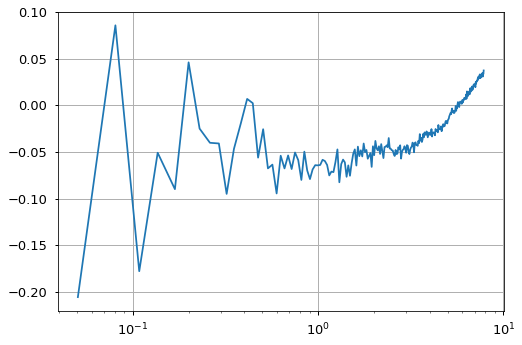

In [13]:
TNG_PATH = '/global/cscratch1/sd/vboehm/TNG_power_spectra/PS_TNG_1'
cat = ArrayCatalog({'Position' : np.asarray([[1.,1.,1.]])}, BoxSize=[205., 205., 205.])
mesh = cat.to_mesh(Nmesh=512, interlaced=True, compensated=True, window='cic')
r = FFTPower(mesh, mode = '1d')
Fpower = r.power['power'].real[1:]
k = r.power['k'][1:]

TNG_pks = []
TNG_zs  = []
for pw in os.listdir(TNG_PATH):
    if 'Dark' in pw:
        redshift = pw[15:19]
        TNG_pks.append(np.loadtxt(os.path.join(TNG_PATH,pw)))
        TNG_zs.append(redshift)
        
TNG_zs  = np.asarray(TNG_zs, dtype=float)
index   = np.argsort(TNG_zs)
TNG_pks = np.asarray(TNG_pks, dtype=float)[index]
TNG_zs  = TNG_zs[index]

TNG_shotnoise = 0.004410944
TNG_Nyquist   = max(k)
print(max(k))

interp = scipy.interpolate.RectBivariateSpline(k, TNG_zs, TNG_pks.T[:len(k), :]-TNG_shotnoise)

def interp_TNG(k,z):
    k = np.asarray(k)
    if k.ndim==0:
        if k<TNG_Nyquist:
            result = interp(k,z)
        else:
            result = interp(TNG_Nyquist,z)*TNG_Nyquist**2*k**(-2)
    else:
        index1 = np.where(k<=TNG_Nyquist)
        index2 = np.where(k>TNG_Nyquist)
        result = np.zeros(k.shape)
        result[index1]= np.squeeze(interp(k[index1],z))
        result[index2]= interp(TNG_Nyquist,z)*TNG_Nyquist**2*k[index2]**(-2)
    
    return np.squeeze(result)

# TNG is systematically low at low k
cosmo = Planck15.clone(P_k_max=50, perturb_sampling_stepsize=0.01,nonlinear=True)
plt.semilogx(k,(interp_TNG(k,0)-cosmo.get_pk(k,0.))/cosmo.get_pk(k,0.))
plt.grid()
plt.show()

### load halofit sensitivity analysis

In [14]:
out = np.load(os.path.join(PLOTPATH,'boosts-3.npz'))

In [15]:
from scipy.interpolate import interp1d
DeltaCL = interp1d(np.logspace(0,4,1000),(out['upper']-out['lower'])/2)

In [21]:
yt   = runs['256']['no_interp']['1.0'].theory_cls['1.0']['clkk']
L    = runs['256']['no_interp']['1.0'].theory_cls['1.0']['L']
ind = np.where(L<1e4)

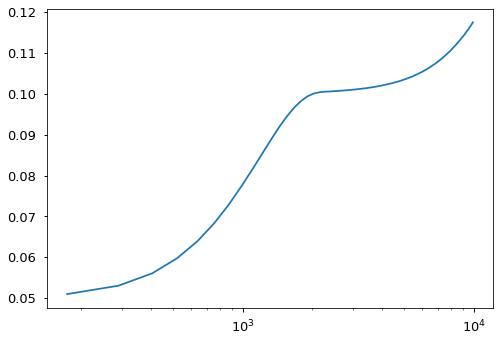

In [22]:
plt.semilogx(L[ind],DeltaCL(L[ind])/yt[ind])

### list all possible run files

In [ ]:
# run_dir   = '../runs'

# githashes = os.listdir(run_dir)
# for githash in githashes:
#     print(githash)
#     path = os.path.join(run_dir,githash)
#     print(os.listdir(path))

### plot function

In [17]:
def plot(z1_runs, boxsizes, interps, zss, labels, name, noise=None, other = True, other_label=[''], nplots=2, Ns=[100.], fsky =0.1, halofit_uncert=False, shape_noise=False):
    
    colors = ['mediumseagreen','coral','royalblue']
    colors2= ['darkgreen', 'firebrick','darkblue']
    if nplots == 2:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(2,1)})
    elif nplots ==1:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(8,4))
        ax = [ax]
    else:
        raise ValueError('number of plots not supported')
        
    
    
    for jj, zs in enumerate(np.unique(zss)):
        interp=interps[0]
        boxsize=str(boxsizes[0])
        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']
        if len(np.unique(zss))==1:
            ax[0].loglog(L,x*yt, label='HaloFit', color=colors2[jj])
        else:
            ax[0].loglog(L,x*yt, color=colors2[jj])
            
        if other:
            z    = z1_runs[boxsize][interp][str(zs)].other_cls[str(zs)]['clkk']
            ax[0].loglog(L,x*z, label=other_label, color='gray')
        
    for ii, (boxsize, interp, zs, label) in enumerate(zip(boxsizes,interps,zss, labels)):

        boxsize=str(boxsize)
        print(boxsize, interp, zs, label)

        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        y    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk']
        yerr = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk_std']/z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['N']
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']

        
        if len(np.unique(zss))==1:
            ax[0].set_title('$z_{source}$=%.1f'%zs,fontsize=16)
        
        if len(np.unique(zss))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, $z_s=$%.1f'%(label,zs), color=colors[ii])
        elif len(np.unique(boxsizes))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, %s Mpc/h'%(label,boxsize), color=colors[ii])
        else:
            ax[0].loglog(L,x*y, label='MADLens%s'%(label), color=colors[ii])
        
        if halofit_uncert:
            ind =np.where(L<=10000)
            LL = L[ind]
            xx = LL*(LL+1.)/2./np.pi
            ax[0].fill_between(LL, xx*(yt[ind]-DeltaCL(LL)), xx*(yt[ind]+DeltaCL(LL)),color='gray', label='HaloFit accuracy', alpha=0.2, zorder=--1)
        
        if noise is not None:
            noise_smooth = np.convolve(noise,np.ones(20)/20., mode='same')
            ax[0].loglog(L,x*noise, label='measured shot noise', color='steelblue')
            #ax[0].loglog(L,x*noise_smooth, color='steelblue')
            
        if ii ==len(zss)-1:
            lss = ['-.','--']
            for ls, N in enumerate(Ns):
                Cl_shape = compute_shape_noise_power(sigma_e=0.4,n=N,fsky=fsky)
                Cl_shape*=(np.pi/(180.*60.))**2
                ax[0].loglog(L,x*Cl_shape, label='shape noise $n{=}$%d$\mathrm{arcmin}^{-2}$, $f_{sky}{=}$%.1f'%(N,fsky), color='palevioletred', ls=lss[ls])  
        
        handles, labels = ax[0].get_legend_handles_labels()
        
        print(labels)
        ratio = (y-yt)/yt
        ratio_error = (yerr)/yt 
        if nplots>1:
            ax[1].semilogx(L,ratio, color=colors[ii])
            ax[1].fill_between(L,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
            if shape_noise and ii ==len(zss)-1:
                ax[1].fill_between(L, -Cl_shape/yt, Cl_shape/yt,color='palevioletred', alpha=0.2)
            if halofit_uncert:
                ind =np.where(L<=10000)
                LL = L[ind]
                ax[1].fill_between(LL, (-DeltaCL(LL))/yt[ind], (+DeltaCL(LL))/yt[ind],color='gray', alpha=0.2)
                ax[1].set_ylim(-0.30,0.30)
            else:
                ax[1].set_ylim(-0.15,0.15)
            ax[1].set_ylabel('relative difference')
            ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)
            ax[1].set_xlabel('$L$',fontsize=16)
        else:
            ax[0].set_xlabel('$L$',fontsize=16)
        
        ax[0].set_ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
        
        if boxsize == '512':
            ax[0].set_xlim(100,10000)
            ax[0].set_ylim(5e-5/2./np.pi,5e-3/2./np.pi)
        else:
            ax[0].set_xlim(200,10000)
            ax[0].set_ylim(6e-5/2./np.pi,3e-2/2./np.pi)
    if np.any(noise==None):
        offset = len(Ns)
    else:
        offset = len(Ns)+2
        
#     first_legend = ax[0].legend(handles=handles[-offset::], loc='lower right',fontsize=14,framealpha=0.95)

#     # Add the legend manually to the current Axes.
#     #ax_ = plt.gca().add_artist(first_legend)
#     ax[0].add_artist(first_legend) 
#     if len(np.unique(zss))>1:
#         sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99)
#         ax[0].add_artist(sec_legend) 
#     else:
#         sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99)
#         ax[0].add_artist(sec_legend) 
    if nplots>1:
        ax[1].grid()
    plt.savefig(os.path.join(PLOTPATH,'%s.pdf'%name),bbox_inches='tight')
    plt.show()

In [18]:
boxsizes        = [1024,512,256,128]
interpolations  = ['interp', 'no_interp']
specials        = ['highres', '11step']
redshifts       = ['0.8', '1.0', '1.2']

runs={}
for boxsize in boxsizes:
    runs[str(boxsize)]={}
    for interp in interpolations:
        runs[str(boxsize)][interp]={}
        for special in specials:
            runs[str(boxsize)][interp][special]={}

In [19]:
runs

{'1024': {'interp': {'highres': {}, '11step': {}},
  'no_interp': {'highres': {}, '11step': {}}},
 '512': {'interp': {'highres': {}, '11step': {}},
  'no_interp': {'highres': {}, '11step': {}}},
 '256': {'interp': {'highres': {}, '11step': {}},
  'no_interp': {'highres': {}, '11step': {}}},
 '128': {'interp': {'highres': {}, '11step': {}},
  'no_interp': {'highres': {}, '11step': {}}}}

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
1 maps were produced in this run
Measuring Cls...
Loading map 0 of 1...
Computing theory Cls....
loading Pks....


/global/homes/v/vboehm/.local/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1190: ComplexWarning: Casting complex values to real discards the imaginary part
  ye, kx, ky, s)


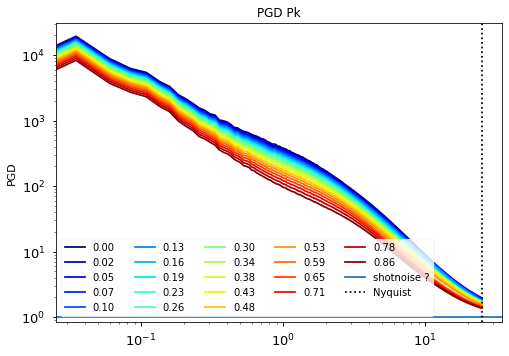

In [20]:
run = Run(githash='3bbfdfb', label='integrated_Pk', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)
fN = run.get_Pks()


if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run
    
run.get_other_cls(run.params['zs_source'][0], other=run.interp_PGD, bink=run.measured_cls[str(run.params['zs_source'][0])]['L'])
shotnoise = run.pm.BoxSize.prod()/(run.pm.Nmesh.prod())
# PGD is continuous
plt.title('PGD Pk')
colors = plt.cm.jet(np.linspace(0,1,len(run.pks.keys())))
for ii, zf in enumerate(sorted(run.pks.keys())):
    plt.loglog(run.pks_PGD[zf].power['k'],abs(run.pks_PGD[zf].power['power']), label='%.2f'%float(zf),c=colors[ii])
plt.axhline(shotnoise,label='shotnoise ?')
plt.axvline(fN,ls=':', color='black', label='Nyquist')
plt.legend(ncol=5,loc='lower left')
plt.ylabel('PGD')
plt.show()

In [327]:
run = Run(githash='f164b59', label='whitenoise', rnum=0, local_path='../')
run.fill_cl_dicts(downsample=False)
white_noise = run.measured_cls['1.0']['clkk']

white_map = run.get_map(1.,0)

Loading run with BoxSize 256, Nmesh 128, SourceRedshift 1.00, PGD False and interpolation False.
1 maps were produced in this run
Measuring Cls...
Loading map 0 of 1...
Computing theory Cls....
Loading map 0 of 1...


In [317]:
run = Run(githash='f164b59', label='cross_test', rnum=0, local_path='../')
run.fill_cl_dicts(downsample=False)
comp_cl = run.measured_cls['1.0']['clkk']

comp_map = run.get_map(1.,0)

Loading run with BoxSize 256, Nmesh 128, SourceRedshift 1.00, PGD False and interpolation False.
1 maps were produced in this run
Measuring Cls...
Loading map 0 of 1...
Computing theory Cls....
Loading map 0 of 1...


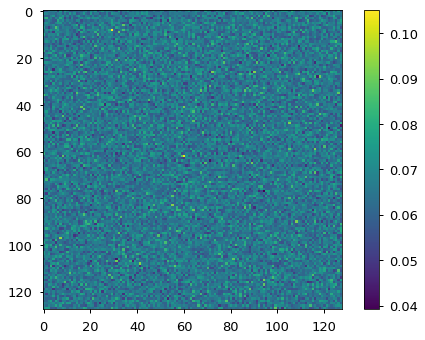

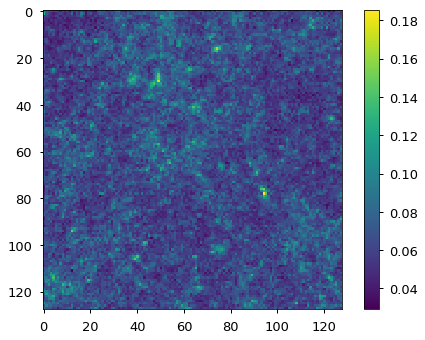

In [328]:
plt.imshow(white_map)
plt.colorbar()
plt.show()
plt.imshow(comp_map)
plt.colorbar()

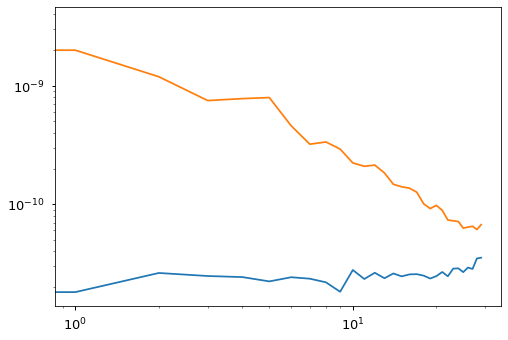

In [329]:
plt.loglog(white_noise)
plt.loglog(comp_cl)

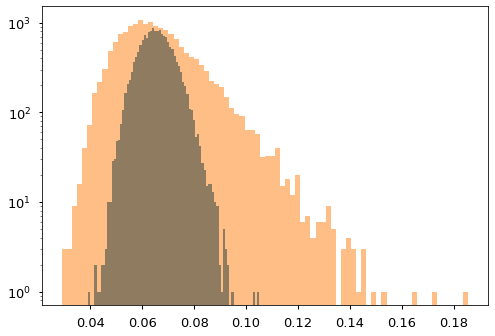

In [330]:
_=plt.hist(white_map.value.flatten(), log=True, bins=80)
_=plt.hist(comp_map.value.flatten(), log=True, bins=80, alpha=0.5)
#x/ q confusion, too large dynamical range

In [24]:
cross_power = FFTPower(first=white_map,second=corr_map, mode='1d').power
power1 = FFTPower(first=white_map,second=white_map, mode='1d').power
power2 = FFTPower(first=corr_map,second=corr_map, mode='1d').power

/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


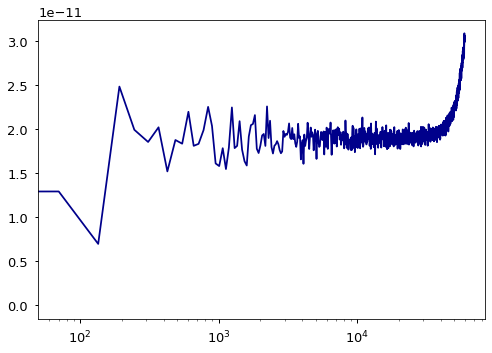

In [25]:
plt.semilogx(cross_power['k'],power1['power']/10.,color='darkblue')

/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


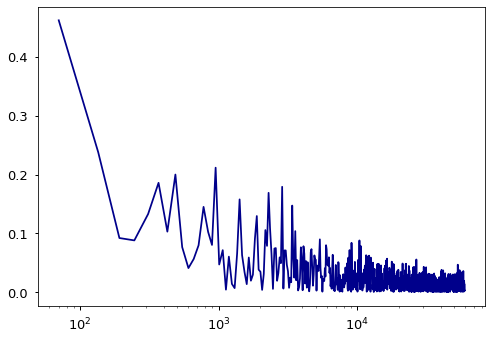

In [26]:
plt.semilogx(cross_power['k'],abs(cross_power['power'])/abs(np.sqrt(power1['power']*power2['power'])),color='darkblue')

256 no_interp 1.0 , no interp.
['HaloFit', 'MADLens, no interp.', 'measured shot noise', 'shape noise $n{=}$40$\\mathrm{arcmin}^{-2}$, $f_{sky}{=}$0.1', 'HaloFit accuracy']


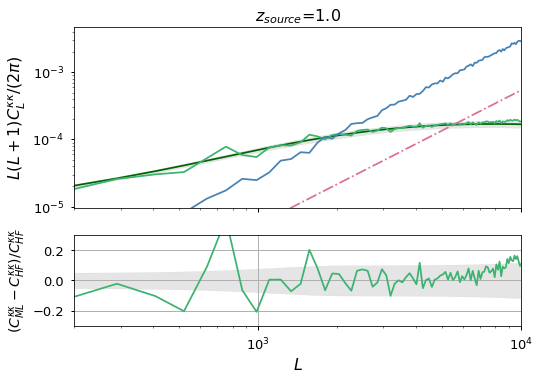

In [27]:
plot(runs, boxsizes=[256], interps=['no_interp'], zss=[1.0], labels=[', no interp.'],other=False, other_label='integrated measured $P_k$', noise=white_noise, nplots=2, name='int_comp', Ns=[40],halofit_uncert=True)
# match to tail of green line

In [28]:
run = Run(githash='859f754', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 0.80, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


In [29]:
run = Run(githash='5913840', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


In [30]:
run = Run(githash='a349dc9', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.20, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


512 interp 0.8 
['MADLens, $z_s=$0.8']
512 interp 1.0 
['MADLens, $z_s=$0.8', 'MADLens, $z_s=$1.0']
512 interp 1.2 
['MADLens, $z_s=$0.8', 'MADLens, $z_s=$1.0', 'MADLens, $z_s=$1.2', 'shape noise $n{=}$30$\\mathrm{arcmin}^{-2}$, $f_{sky}{=}$0.1']


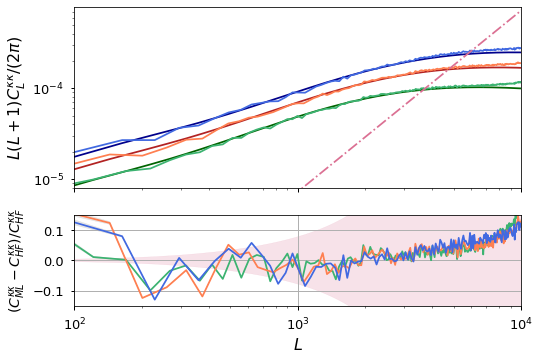

In [31]:
plot(runs, boxsizes=[512, 512, 512], interps=['interp','interp','interp'], zss=[0.8, 1.0, 1.2], other=False,labels=['','',''], name='redshift_comp', Ns=[30], shape_noise=True)

In [32]:
# run = Run(githash='49b5863', label='transfer_test', rnum=0, local_path='../')
# # this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# # individual clkk can be loaded with get_measured_cls/get_theory_cls
# run.fill_cl_dicts(downsample=False)


# if run.params['interpolate']:
#     runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
# else:
#     runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run
#plot(runs, boxsizes=[512], interps=['interp'], zss=[0.5], other=False,labels=[''], name='small_redshift', Ns=[30])

In [33]:
run = Run(githash='32896b0', label='cross_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
#run.fill_cl_dicts(downsample=False)
map_highres = run.get_map(1.,0)
comp_map = runs['512']['interp']['1.0'].get_map(1.,0)

Loading run with BoxSize 512, Nmesh 1024, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...
Loading map 0 of 5...


In [139]:
# run = Run(githash='211ec75', label='cross_test', rnum=0, local_path='../')
# map_highres_05 = run.get_map(0.5,0)
run = Run(githash='0d2350a', label='cross_test', rnum=0, local_path='../')
comp_map_noPGD = run.get_map(1.0,0)

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...


/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


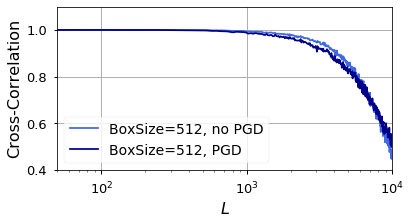

In [146]:
cross_power = FFTPower(first=map_highres,second=comp_map, mode='1d').power
cross_power2 = FFTPower(first=map_highres,second=comp_map_noPGD, mode='1d').power
power1 = FFTPower(first=comp_map,second=comp_map, mode='1d').power
power2 = FFTPower(first=map_highres,second=map_highres, mode='1d').power
power3 = FFTPower(first=comp_map_noPGD,second=comp_map_noPGD, mode='1d').power
# comparison with no PGD
# cross_power_05 = FFTPower(first=map_highres_05,second=comp_map_05, mode='1d').power
# power1_05 = FFTPower(first=comp_map_05,second=comp_map_05, mode='1d').power
# power2_05 = FFTPower(first=map_highres_05,second=map_highres_05, mode='1d').power

plt.figure(figsize=(6,3))
plt.plot(cross_power['k'],abs(cross_power2['power'])/abs(np.sqrt(power3['power']*power2['power'])),color='royalblue', label='BoxSize=512, no PGD')
plt.semilogx(cross_power['k'],abs(cross_power['power'])/abs(np.sqrt(power1['power']*power2['power'])),color='darkblue', label='BoxSize=512, PGD')
plt.xlabel('$L$',fontsize=16)
plt.ylabel('Cross-Correlation',fontsize=16)
plt.xlim(50,1e4)
plt.ylim(0.4,1.1)
plt.legend(fontsize=14)
plt.grid()
plt.savefig(os.path.join(PLOTPATH,'cross_corr.pdf'),bbox_inches='tight')
plt.show()

/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


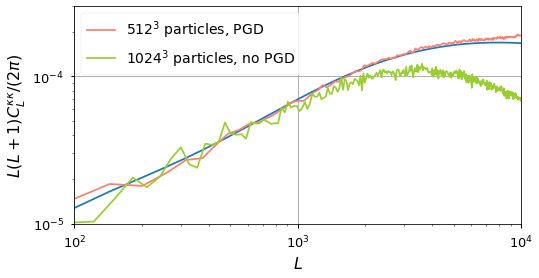

In [71]:
plt.figure(figsize=(8,4))
l= cross_power['k']
halofit = runs['512']['interp']['1.0'].theory_cls['1.0']['clkk']
LL = runs['512']['interp']['1.0'].theory_cls['1.0']['L']

runs['512']['interp']['1.0'].fill_cl_dicts(downsample=False)
pp = runs['512']['interp']['1.0'].measured_cls['1.0']['clkk']
L = runs['512']['interp']['1.0'].measured_cls['1.0']['L']
plt.loglog(LL,LL*(LL+1)/2./np.pi*halofit)
plt.loglog(L,L*(L+1)/2./np.pi*pp,label='$512^3$ particles, PGD', color='salmon')
plt.loglog(l,l*(l+1)/2./np.pi*power2['power'],label='$1024^3$ particles, no PGD', color='yellowgreen')
plt.xlim(100,1e4)
plt.ylim(1e-5,3e-4)
plt.ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
plt.xlabel('$L$',fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.savefig(os.path.join(PLOTPATH,'PGD_Cls.pdf'),bbox_inches='tight')

In [77]:

run = Run(githash='87b9348', label='cross_test', rnum=0, local_path='../')
runs['256']['interp']['11step']['1.0']=run
runs['256']['interp']['11step']['1.0'].fill_cl_dicts(downsample=False)


Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

In [133]:
real_map = runs['256']['interp']['1.0'].get_map(1.0,0)

Loading map 0 of 5...


In [80]:
run = Run(githash='1bfb819', label='cross_test', rnum=0, local_path='../')
runs['256']['interp']['1.0']=run
runs['256']['interp']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

In [97]:
run = Run(githash='e18db0b', label='cross_test', rnum=0, local_path='../')
runs['256']['no_interp']['1.0']=run
runs['256']['no_interp']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
less maps produces than requested. Requested:5 Produced:4
4 maps were produced in this run
Measuring Cls...
Loading map 0 of 4...
Loading map 1 of 4...
Loading map 2 of 4...
Loading map 3 of 4...
Computing theory Cls....


True

In [118]:
run = Run(githash='73d941c', label='cross_test', rnum=0, local_path='../')
runs['256']['no_interp']['11step']['1.0']=run
runs['256']['no_interp']['11step']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

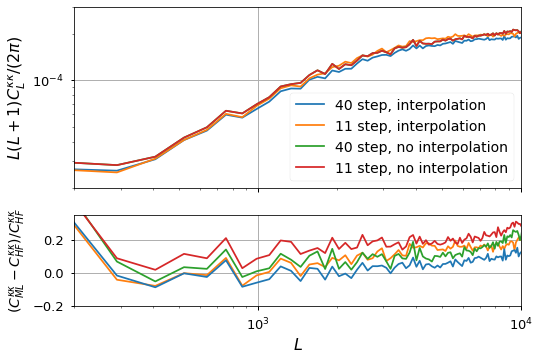

In [137]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(2,1)})

LL= runs['256']['no_interp']['1.0'].measured_cls['1.0']['L']
x = LL*(LL+1.)/2./np.pi
halofit = runs['256']['interp']['1.0'].theory_cls['1.0']['clkk']
p3 = ax[0].loglog(LL,x*runs['256']['interp']['1.0'].measured_cls['1.0']['clkk'], label='40 step, interpolation')
p2=ax[0].loglog(LL,x*runs['256']['interp']['11step']['1.0'].measured_cls['1.0']['clkk'], label='11 step, interpolation')
p =ax[0].loglog(LL,x*runs['256']['no_interp']['1.0'].measured_cls['1.0']['clkk'], label='40 step, no interpolation')
p4 =ax[0].loglog(LL,x*runs['256']['no_interp']['1.0'].measured_cls['1.0']['clkk'], label='11 step, no interpolation')

#plt.loglog(LL,x*halofit, label='halofit')
ax[0].set_xlim(200,1e4)
ax[0].set_ylim(2e-5,3e-4)
ax[0].set_ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=16)
ax[0].legend(fontsize=14)
ax[0].grid()
ref = halofit#runs['256']['interp']['1.0'].measured_cls['1.0']['clkk']
ax[1].semilogx(LL,(runs['256']['interp']['11step']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p2[0].get_color())
ax[1].semilogx(LL,(runs['256']['no_interp']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p[0].get_color())
ax[1].semilogx(LL,(runs['256']['interp']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p3[0].get_color())
ax[1].semilogx(LL,(runs['256']['no_interp']['11step']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p4[0].get_color())
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)
ax[1].set_ylim(-0.2,0.35)
ax[1].grid()
plt.savefig(os.path.join(PLOTPATH,'Interp_Cls.pdf'),bbox_inches='tight')
plt.show()
# different framing

In [199]:
run = Run(githash='6023110', label='deriv_test_32_plus', rnum=0, local_path='../')
map_plus = run.get_map(1.0,0)

run = Run(githash='6023110', label='deriv_test_32_minus', rnum=0, local_path='../')
map_minus = run.get_map(1.0,0)

Loading run with BoxSize 256, Nmesh 64, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...
Loading run with BoxSize 256, Nmesh 64, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...


In [191]:
import scipy.special as special

In [297]:
jvp_32 = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/23c8e24/deriv_test_32b_jvp0/maps/jvp_zsource10_map0_of1.npy')
jvp_1 = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/9df26fc/deriv_test_1b_jvp0/maps/jvp_zsource10_map0_of1.npy')

map_32 = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/23c8e24/deriv_test_32b_jvp0/maps/map_decon_zsource10_map0_of1.npy')
map_1 = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/9df26fc/deriv_test_1b_jvp0/maps/map_decon_zsource10_map0_of1.npy')

# jvp = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/93367f9/deriv_test_interp_vjp0/maps/jvp_zsource10_map0_of1.npy')
# map_orig = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/445db8e/deriv_test_32_jvp0/maps/map_decon_zsource10_map0_of1.npy')
# map_mod = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/23c8e24/deriv_test_32b_jvp0/maps/map_decon_zsource10_map0_of1.npy')

In [298]:


jvp_1 = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/908a0da/deriv_test_1_jvp0/maps/jvp_zsource10_map0_of1.npy')
jvp = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/7d6971b/deriv_test_32_jvp0/maps/jvp_zsource10_map0_of1.npy')
map_minus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/7d6971b/deriv_test_32_minus0/maps/map_decon_zsource10_map0_of1.npy')
map_plus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/7d6971b/deriv_test_32_plus0/maps/map_decon_zsource10_map0_of1.npy')

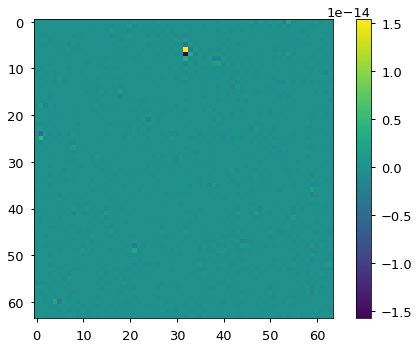

In [299]:
plt.imshow((map_32-map_1).reshape(64,64))
plt.colorbar()
plt.show()

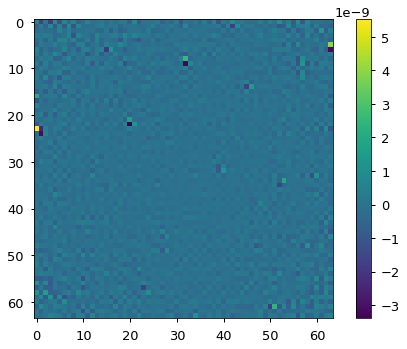

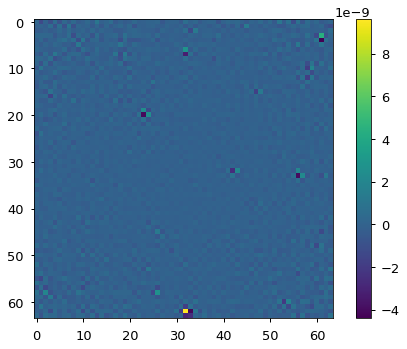

In [300]:
plt.imshow(jvp.reshape(64,64))
plt.colorbar()
plt.show()

plt.imshow(jvp_32.reshape(64,64))
plt.colorbar()
plt.show()
## test cases:
# linear test
# no displacement
# disable replica
# single rank (1 node)
# lower resolution in lening map

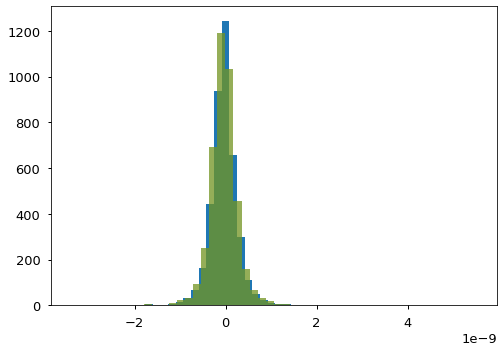

In [301]:
_ = plt.hist((map_plus-map_minus).flatten(),bins=50)
_ = plt.hist(jvp.flatten(),bins=50, alpha=0.5)
_ = plt.hist(jvp_1.flatten(),bins=50, alpha=0.5)
# histograms agree

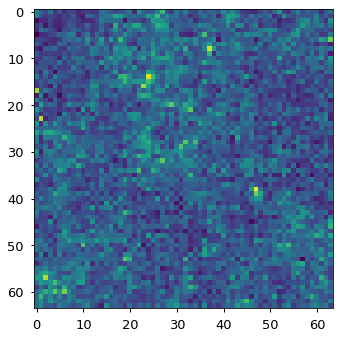

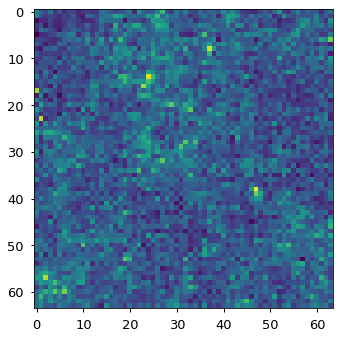

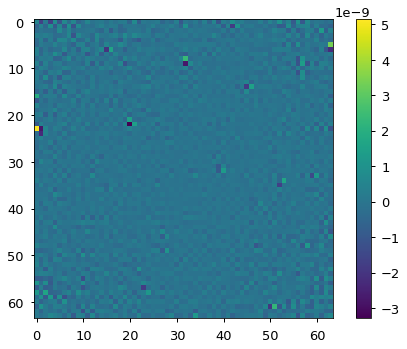

In [302]:
plt.imshow(map_minus.reshape(64,64))
plt.show()
plt.imshow(map_plus.reshape(64,64))
plt.show()
plt.imshow((map_plus-map_minus).reshape(64,64))
plt.colorbar()
plt.show()
# make it more lensing, bigger impact

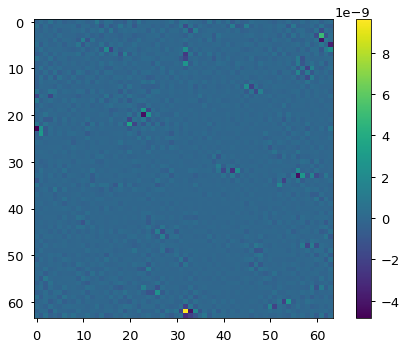

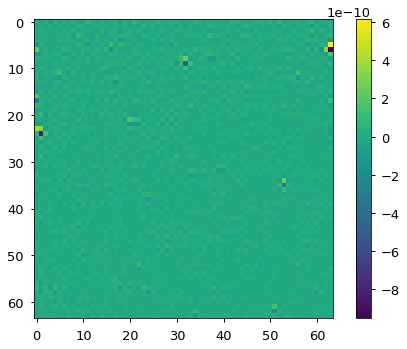

In [303]:
# higher numerical inaccuracies, but at least similar
plt.imshow(jvp_32.reshape(64,64)-(map_plus-map_minus).reshape(64,64))
plt.colorbar()
plt.show()
# higher numerical inaccuracies, but at least similar
plt.imshow(jvp.reshape(64,64)-(map_plus-map_minus).reshape(64,64))
plt.colorbar()
plt.show()

### plot results

In [ ]:
plt.figure()
plt.title('convergence histogram')
#_ = plt.hist(mymap.value.flatten(),bins=100,density=True, log=True)
_ = plt.hist(down_sampled_map.value.flatten(),bins=100,density=True, log=True)
mean = np.mean(mymap)
plt.axvline(x=mean,color='crimson', label='mean=%.1f'%mean)
plt.legend(fontsize=14)
plt.show()

In [ ]:
down_sampled_map = downsample_map(mymap,512,z1_runs['256']['interp']['1.0'].params)
plt.figure(figsize=(8,8))
plt.title('convergence map')
plt.imshow(np.log(down_sampled_map+1),cmap='viridis')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.colorbar()
plt.show()

In [ ]:

ll   = len(z1_runs['256']['interp']['1.0'].params['zs_source'])

plt.figure(figsize=(ll*5,4))
for ii, zs in enumerate(z1_runs['256']['interp']['1.0'].params['zs_source']):
    
    x    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['L']
    y    = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk']
    yerr = z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.0'].measured_cls[str(zs)]['N']
    yt   = z1_runs['256']['interp']['1.0'].theory_cls[str(zs)]['clkk']
    
    ratio = (y-yt)/yt
    ratio_error = (yerr)/yt 
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
    ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
    ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
    ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
    ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
    ax[0].grid()
    
    ax[1].semilogx(x,ratio, color='mediumseagreen')
    ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
    ax[1].grid()
    ax[1].set_ylim(-0.1,0.1)
    ax[1].set_ylabel('relative difference')
    ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
    ax[1].set_xlabel('$L$',fontsize=14)
    ax[0].set_xlim(200,10000)
    ax[0].set_ylim(1e-4,2e-3)

In [ ]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['no_interp'][1.0].params['zs_source'])

plt.figure(figsize=(ll*5,4))

    
x    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['L']
y    = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['no_interp'][1.0].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['no_interp'][1.0].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,2e-3)

In [ ]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['1.2'].params['zs_source'])
zs   = 1.2
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['1.2'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['1.2'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(1e-4,3e-3)

In [ ]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.8'].params['zs_source'])
zs   = 0.8
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.8'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.8'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

In [ ]:
# interpolation helps even at 40 steps!

ll   = len(z1_runs['256']['interp']['0.5'].params['zs_source'])
zs   = 0.5
plt.figure(figsize=(ll*5,4))

x    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['L']
y    = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk']
yerr = z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['clkk_std']/z1_runs['256']['interp']['0.5'].measured_cls[str(zs)]['N']
yt   = z1_runs['256']['interp']['0.5'].theory_cls[str(zs)]['clkk']

ratio = (y-yt)/yt
ratio_error = (yerr)/yt 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(4,3)})
ax[0].set_title('$z_s$=%.1f'%zs,fontsize=14)
ax[0].loglog(x,x**2*yt, label='HaloFit', color='darkblue')
ax[0].loglog(x,x**2*y, label='MADLens', color='mediumseagreen')
ax[0].fill_between(x, x**2*(y-yerr), x**2*(y+yerr),color='gray', alpha=0.2)
ax[0].grid()

ax[1].semilogx(x,ratio, color='mediumseagreen')
ax[1].fill_between(x,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-0.1,0.1)
ax[1].set_ylabel('relative difference')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('$L^2 C^{\kappa \kappa}_L$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=14)
ax[0].set_xlim(200,10000)
ax[0].set_ylim(8e-5,1e-3)

In [127]:
z1_runs['256']['interp'].keys()

dict_keys(['1.0', '0.5'])

In [128]:
z1_runs['256']['interp']['0.5']